In [260]:
import numpy as np

# TVM imports
import tvm
from tvm import relay
from tvm.contrib.download import download_testdata
from tvm.contrib import graph_executor

# PyTorch imports
import torch
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights

# Image processing
from PIL import Image
import matplotlib.pyplot as plt

### Load a pretrained PyTorch model

In [261]:
model_name = "resnet50"
model = getattr(models, model_name)(weights=ResNet50_Weights.DEFAULT)
model = model.eval()

# We grab the TorchScripted model via tracing
input_shape = [1, 3, 224, 224]
input_data = torch.randn(input_shape)
scripted_model = torch.jit.trace(model, input_data).eval()

### Laod random image

In [262]:
img_url = "https://www.wallpaperup.com/uploads/wallpapers/2014/01/02/213040/661dbafafce180b119d5396c80050393.jpg"
img_path = download_testdata(img_url, "sg.jpg", module="data")
img = Image.open(img_path).resize((224, 224))

# Preprocess the image and convert to tensor
my_preprocess = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
    ]
)

img = my_preprocess(img)
img = np.expand_dims(img, 0)

### Helper functions for importing the graph to Relay and compiling the model


In [264]:
def quantize(mod, params, quantize_arg):
    with relay.quantize.qconfig(calibrate_mode='global_scale', dtype_input=quantize_arg, dtype_weight=quantize_arg, dtype_activation=quantize_arg, global_scale=8.0):
        modd = relay.quantize.quantize(mod, params)
        return modd

def get_model(quantize_arg=None, image=img):
    input_name = "input0"
    shape_list = [(input_name, image.shape)]
    mod, params = relay.frontend.from_pytorch(scripted_model, shape_list)
    if quantize_arg != "Unquantized":
        mod = quantize(mod, params, quantize_arg)
    return mod, params


def compile_model(target_arg, quantize_arg=""):
    mod, params = get_model(quantize_arg)
    with tvm.transform.PassContext(opt_level=3):
        lb = relay.build(mod, target=target_arg, params=params)
    return lb

### Hardware configuration

In [265]:
target = tvm.target.Target("llvm", host="llvm")
dev = tvm.cpu(0)

dtype = "float32"

### Running inference for different quantization schemes

In [273]:
res_dict = {}
keys = ["Unquantized", "int16", "int8", "int4", "int2", "bool", "int7", "int6"]

for key in keys:
    try:
        lib = compile_model(target, key)
        m = graph_executor.GraphModule(lib["default"](dev))
        # Set inputs
        m.set_input("input0", tvm.nd.array(img.astype(dtype)))
        # Execute and benchmark
        res = m.benchmark(dev)
        res_dict[key] = (res.mean,res.std)
    except Exception as e:
        res_dict[key] = "Not supported"

### Results

In [275]:
for item in res_dict.items():
    key, value = item
    if value == "Not supported":
        print(f"{key}: {value}")
    else:
        mean, std = value
        print(f"{key}: mean = {mean}, std = {std}")

Unquantized: mean = 0.063074648, std = 0.0032443618683149385
int16: mean = 0.066792128, std = 0.005332998579570033
int8: mean = 0.14741260399999997, std = 0.003983096202210534
int4: Not supported
int2: Not supported
bool: mean = 0.041592439999999994, std = 0.0022442325897286132
int7: Not supported
int6: Not supported


### Plotting results

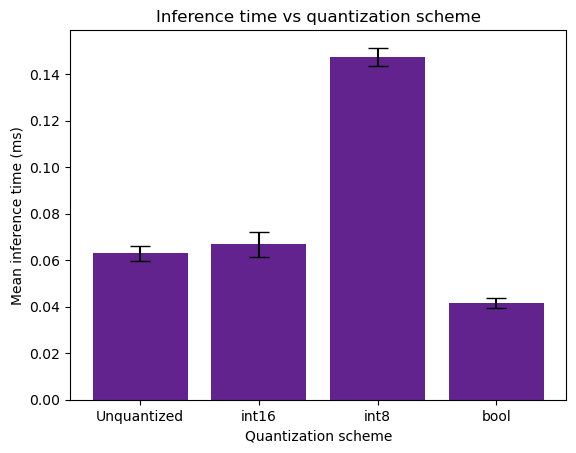

In [291]:
means = [res_dict[key][0] for key in keys if res_dict[key] != "Not supported"]
stds = [res_dict[key][1] for key in keys if res_dict[key] != "Not supported"]
keys = [key for key in keys if res_dict[key] != "Not supported"]

fig, ax = plt.subplots()
ax.bar(keys, means)
ax.bar(keys, means, yerr=stds, align='center', alpha=0.7, color='purple', ecolor='black', capsize=7)
ax.set_ylabel("Mean inference time (ms)")
ax.set_xlabel("Quantization scheme")
ax.set_title("Inference time vs quantization scheme")
plt.show()

## Conclusion
As we can see **int4**, **int2**, **int6** and **int7** are not supported by TVM compiler. **Int4** and **int2** are not supported because the number of bits must be dividable by 8 and base must be >= **8** in *int_base* notation. Although both **int7** and **int6** have base smaller then 8, I suspect that they are also not working because in code for quantization there is setting *"weight_scale": "power2"* which means that the scale of the weights must be a **power of 2**. This is not the case for **int7** and **int6**.

### Inference time vs quantization scheme
We can see that **bool quantization** scheme is **the fastest** in terms of inference time. This is expected because **bool quantization** scheme is the most aggressive quantization scheme. It is also the **least accurate** quantization scheme.
On the other hand, **int8** quantization scheme is the **slowest** and **int16** is close to unqauntized one. This is not to be expected because **int8** quantization scheme is the second most aggressive and should be faster than **int16**, but also less accurate.